Nama:

In [ ]:
print("Rahman Aziz Firmansyah")

Rahman Aziz Firmansyah


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, OneHotEncoder, PolynomialFeatures
from sklearn.feature_selection import mutual_info_classif, SelectKBest, VarianceThreshold, mutual_info_regression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, precision_recall_curve, roc_auc_score, roc_curve, r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
import fbprophet
import warnings

(1) Split dataset menjadi trainset (data sampai sebelum tahun 1989), validset (data tahun 1989), dan testset (data tahun 1990)

In [8]:
temp = pd.read_csv("daily-min-temperatures.csv")
temp.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [17]:
temp.columns = ['ds', 'y']
temp.head()

,ds,y
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [18]:
temp['ds'] = pd.to_datetime(temp['ds'])
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3650 non-null   datetime64[ns]
 1   y       3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


In [19]:
trainset = temp[temp['ds'].dt.year < 1989]
validset = temp[temp['ds'].dt.year == 1989]
testset = temp[temp['ds'].dt.year == 1990]

(2) Dengan menggunakan trainset dan validset tentukan nilai yearly_seasonality, weekly_seasonality, dan changepoint_prior_scale yang optimal.

In [33]:
prophet = fbprophet.Prophet(yearly_seasonality=True,
                            daily_seasonality=False,
                            weekly_seasonality=True)

In [34]:
prophet.fit(trainset)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


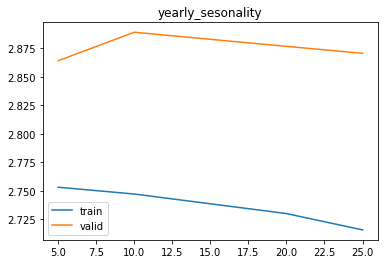

In [24]:
params = [5, 10, 20, 25]
train = []
valid = []

for par in params:
    
    fbprophet2 = fbprophet.Prophet(yearly_seasonality=par)
    fbprophet2.fit(trainset)

    trainset_predict = fbprophet2.predict(trainset[['ds']])['yhat']
    validset_predict = fbprophet2.predict(validset[['ds']])['yhat']

    rmse_train = mean_squared_error(trainset['y'], trainset_predict, squared=False)
    rmse_valid = mean_squared_error(validset['y'], validset_predict, squared=False)

    train.append(rmse_train)
    valid.append(rmse_valid)

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot( x = params, y = valid, label = 'valid')
plt.title('yearly_sesonality')
plt.show()
ys_par = params[np.argmax(valid)]
ys_par

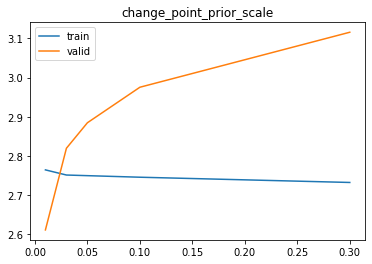

0.3

In [26]:
params = [0.01, 0.03, 0.05, 0.1, 0.3]
train = []
valid = []

for par in params:
    
    fbprophet2 = fbprophet.Prophet(yearly_seasonality=ys_par,
                                   daily_seasonality=False,
                                   weekly_seasonality=False,
                                   changepoint_prior_scale=par)
    fbprophet2.fit(trainset)

    trainset_predict = fbprophet2.predict(trainset[['ds']])['yhat']
    validset_predict = fbprophet2.predict(validset[['ds']])['yhat']

    rmse_train = mean_squared_error(trainset['y'], trainset_predict, squared=False)
    rmse_valid = mean_squared_error(validset['y'], validset_predict, squared=False)

    train.append(rmse_train)
    valid.append(rmse_valid)

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot( x = params, y = valid, label = 'valid')
plt.title('change_point_prior_scale')
plt.show()
cpps_par = params[np.argmax(valid)]
cpps_par

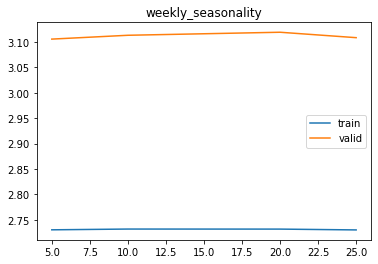

20

In [28]:
params = [5, 10, 20, 25]
train = []
valid = []

for par in params:
    
    fbprophet2 = fbprophet.Prophet(yearly_seasonality=ys_par,
                                   daily_seasonality=False,
                                   weekly_seasonality=par,
                                   changepoint_prior_scale=cpps_par)
    fbprophet2.fit(trainset)

    trainset_predict = fbprophet2.predict(trainset[['ds']])['yhat']
    validset_predict = fbprophet2.predict(validset[['ds']])['yhat']

    rmse_train = mean_squared_error(trainset['y'], trainset_predict, squared=False)
    rmse_valid = mean_squared_error(validset['y'], validset_predict, squared=False)

    train.append(rmse_train)
    valid.append(rmse_valid)

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot( x = params, y = valid, label = 'valid')
plt.title('weekly_seasonality')
plt.show()
ws_par = params[np.argmax(valid)]
ws_par

In [29]:
prophet_final = fbprophet.Prophet(daily_seasonality=False,
                                  weekly_seasonality=ws_par,
                                  yearly_seasonality=ys_par,
                                  changepoint_prior_scale=cpps_par)

In [30]:
prophet_final.fit(trainset)

In [32]:
print(rmse_train, rmse_valid, rmse_test)

2.7317410489639053 3.1193689156561466 3.4115433307943155


(3) Hitung RMSE hasil prediksi testset menggunakan optimized vs unoptimized model. Pilih final model.

In [35]:
trainset_predict_final = prophet_final.predict(trainset[['ds']])['yhat']
validset_predict_final = prophet_final.predict(validset[['ds']])['yhat']
testset_predict_final = prophet_final.predict(testset[['ds']])['yhat']

rmse_train_final = mean_squared_error(trainset['y'], trainset_predict_final, squared=False)
rmse_valid_final = mean_squared_error(validset['y'], validset_predict_final, squared=False)
rmse_test_final = mean_squared_error(testset['y'], testset_predict_final, squared=False)

In [36]:
trainset_predict = prophet.predict(trainset[['ds']])['yhat']
validset_predict = prophet.predict(validset[['ds']])['yhat']
testset_predict = prophet.predict(testset[['ds']])['yhat']

rmse_train = mean_squared_error(trainset['y'], trainset_predict, squared=False)
rmse_valid = mean_squared_error(validset['y'], validset_predict, squared=False)
rmse_test = mean_squared_error(testset['y'], testset_predict, squared=False)

In [37]:
print(rmse_train, rmse_valid, rmse_test)

2.7471129232377365 2.889120344954879 2.9578808519285067


In [38]:
print(rmse_train_final, rmse_valid_final, rmse_test_final)

2.7317410489639053 3.1193689156561466 3.4115433307943155


(4) Tampilkan plot (+scatter plot validset dan testset) dan plot_components dari final model.

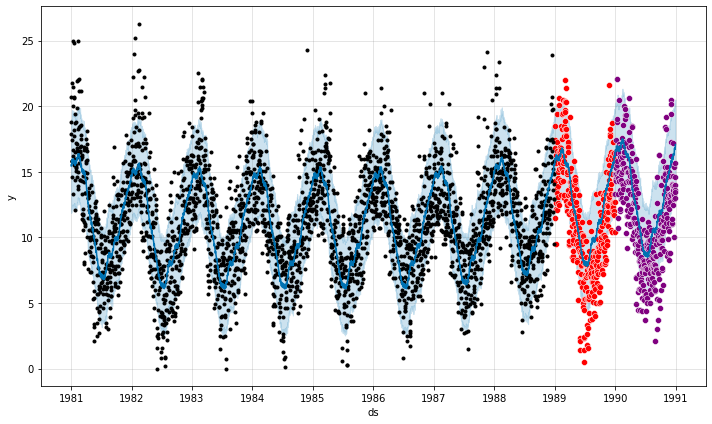

In [42]:
prophet_final.plot(prophet.predict(temp[['ds']]))
sns.scatterplot(data=validset, x='ds', y='y', color='red')
sns.scatterplot(data=testset, x='ds', y='y', color='purple')
plt.show()

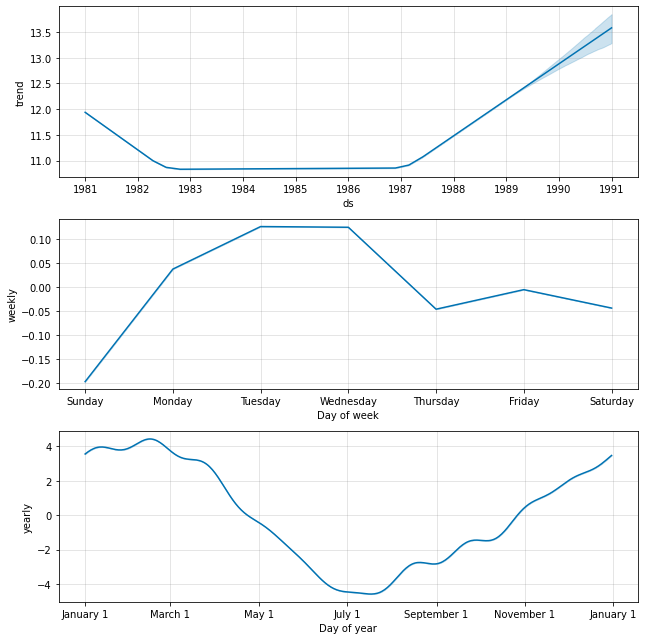

In [44]:
prophet.plot_components(prophet.predict(temp[['ds']]))
plt.show()

(5) Buat prediksi min_temperature harian tahun 5 tahun setelah tanggal terakhir di dataset menggunakan final model. Tampilkan plotnya.

In [46]:
future = prophet_final.make_future_dataframe(5, 'Y')
future

,ds
0,1981-01-01
1,1981-01-02
2,1981-01-03
3,1981-01-04
4,1981-01-05
...,...
2920,1988-12-31
2921,1989-12-31
2922,1990-12-31
2923,1991-12-31


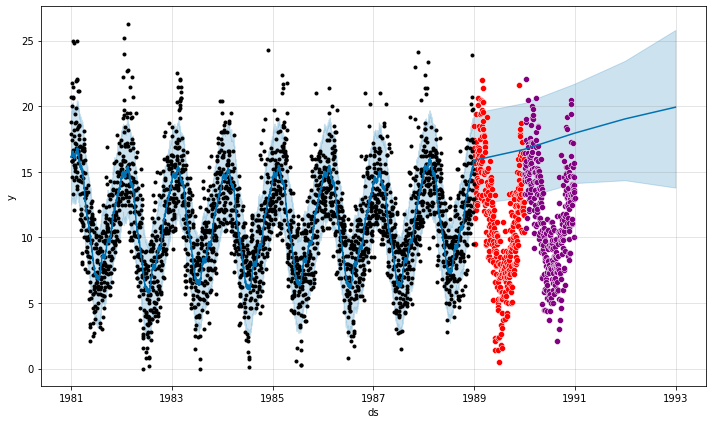

In [47]:
prophet_final.plot(prophet_final.predict(future))
sns.scatterplot(data=validset, x='ds', y='y', color='red')
sns.scatterplot(data=testset, x='ds', y='y', color='purple')
plt.show()

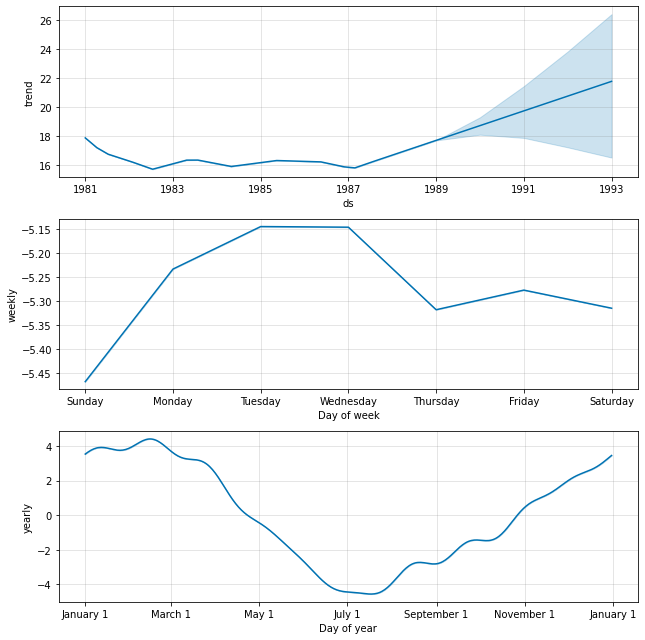

In [48]:
prophet_final.plot_components(prophet_final.predict(future))
plt.show()